## Analysis of Citation Network Among US Patents

This notebook performs an analysis of the citation network among US Patents from 1975 to 1999. The data was sourced from [Stanford Network Analysis Project (SNAP)](https://snap.stanford.edu/data/cit-Patents.html), containing 3,774,768 patent nodes and 16,518,948 citation edges. The analysis focuses on uncovering meaningful patterns and structures within the patent citation network, which can reveal insights into technological fields and influential patents.

### 1. Sampling for Dataset Size Reduction
   - **Objective**: Reduce dataset size while retaining core structure for analysis
   - **Method**: Patent node IDs are remapped to smaller indices, and patent nodes are sampled based on their degree (with equal weightage for both in-degree and out-degree). This helps maintain the essential structures of the citation network while reducing its complexity
   
### 2. Identifying Communities in the Citation Network
   - **Objective**: Uncover meaningful subgroups or communities within the citation network
   - **Method**: The Louvain algorithm is used for community detection by optimizing modularity. The algorithm iteratively groups nodes into communities, maximizing the modularity of the resulting community structure. This process helps identify clusters of patents that are more closely related to one another in terms of citations, potentially revealing technical areas or research domains within the patent ecosystem
   - For each community, we compute summary statistics such as community size, in-degree, out-degree, and percentiles of community sizes. These metrics provide insights into the distribution and characteristics of the communities identified
   
### 3. PageRank Algorithm on Communities
   - **Objective**: Identify the most influential patents within each community detected by the Louvain algorithm
   - **Method**: The PageRank algorithm assigns a rank to each patent (node) within a community based on its incoming citation links, with the assumption that patents with more incoming citations are likely to be more influential
   - Using the algorithm, the most prominent patents in each technical area or research domain can be identified, which can offer insights into the key innovations driving developments in specific fields

---
### 0. Importing Packages and Loading Data

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import concurrent.futures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('cit-Patents.txt', sep='\t', comment='#', header=None, names=['FromNodeID','ToNodeID'])
data = data.dropna(subset=['FromNodeID','ToNodeID'])
print(f'Number of nodes: {pd.concat([data['FromNodeID'], data['ToNodeID']]).nunique():,}')
print(f'Number of edges: {len(data):,}')
display(data.head())

Number of nodes: 3,774,768
Number of edges: 16,518,948


,FromNodeID,ToNodeID
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


---
### 1. Sampling for Dataset Size Reduction

To reduce the complexity of the dataset while preserving its core structure, each node ID is first remapped to a smaller index. Thereafter, nodes are sampled based on the sum of their **in-degree** and **out-degree** to maintain the structural integrity and key network properties for subsequent analysis

- **In-degree**: This represents the number of incoming edges to a node, or how many times a patent is cited by other patents in the dataset. Patents with a high in-degree are typically highly influential and central to the network. Retaining these nodes ensures that significant patents, which have made notable contributions to the field, are preserved in the reduced dataset
  
- **Out-degree**: This refers to the number of outgoing edges from a node, or how many citations a patent makes to other patents. Patents with a high out-degree indicate a strong connectivity to other patents, reflecting the relationships and knowledge exchange within the network. Keeping these nodes is essential for maintaining the interconnectedness and diversity of the citation network


In [3]:
# Remap node IDs to new shorter indices
nodes = pd.concat([data['FromNodeID'], data['ToNodeID']]).unique()
node_mapping = {node: idx for idx, node in enumerate(nodes)}
reverse_node_mapping = {idx: node for node, idx in node_mapping.items()}
data['FromNodeID'] = data['FromNodeID'].map(node_mapping)
data['ToNodeID'] = data['ToNodeID'].map(node_mapping)

,in_degree,out_degree,combined_degree
845110,779,14,793
1884220,0,770,770
1971002,0,745,745
1941493,1,737,738
590805,716,9,725


,cumul_deg,node_share
0,0.000024,0.000000e+00
1,0.000047,2.649169e-07
2,0.000070,5.298339e-07
3,0.000092,7.947508e-07
4,0.000114,1.059668e-06
...,...,...
3774763,1.000000,9.999987e-01
3774764,1.000000,9.999989e-01
3774765,1.000000,9.999992e-01
3774766,1.000000,9.999995e-01


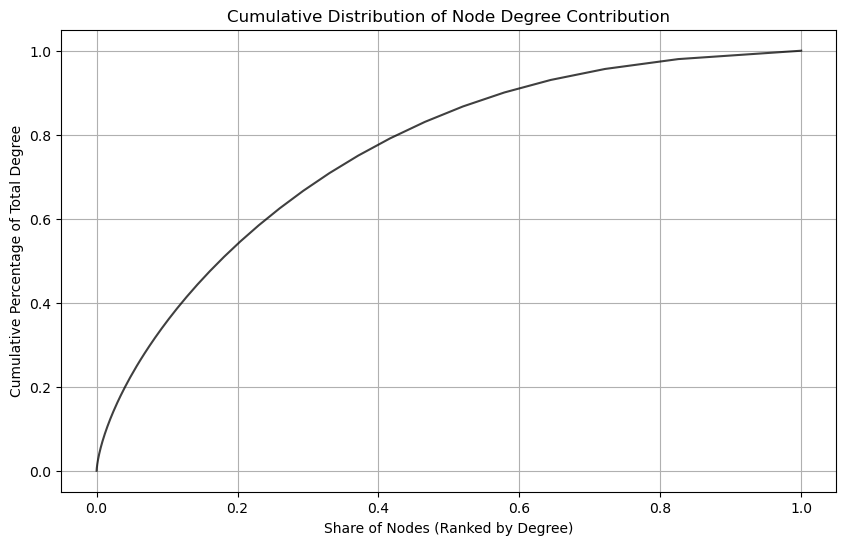

In [4]:
# Calculate node degree
in_degree = data['ToNodeID'].value_counts()
out_degree = data['FromNodeID'].value_counts()
degree = pd.DataFrame({
    'in_degree': in_degree,
    'out_degree': out_degree
}).fillna(0).astype(int)
degree['combined_degree'] = degree['in_degree']+degree['out_degree']
degree = degree.sort_values(by='combined_degree', ascending=False)
display(degree.head())

cumul = pd.DataFrame(degree['combined_degree'].cumsum() / degree['combined_degree'].sum()).reset_index(drop=True).rename(columns={'combined_degree':'cumul_deg'})
cumul['node_share'] = cumul.index / len(cumul)
display(cumul)

plt.figure(figsize=(10, 6))
plt.plot(cumul['node_share'], cumul['cumul_deg'], linestyle='-', color='black', alpha=0.75)
plt.xlabel('Share of Nodes (Ranked by Degree)')
plt.ylabel('Cumulative Percentage of Total Degree')
plt.title('Cumulative Distribution of Node Degree Contribution')
plt.grid(True)
plt.show()

In [5]:
# Sample nodes based on node degree
sample_pptn = 0.4 #Can be adjusted based on computational constraints. E.g., 40% of nodes contains 80% of edges
top_nodes = degree.head(int(len(degree)*sample_pptn)).index
df = data[data['FromNodeID'].isin(top_nodes) & data['ToNodeID'].isin(top_nodes)].reset_index(drop=True)
df.to_csv('sampled_cit-Patents.csv', index=False)

In [6]:
df = pd.read_csv('sampled_cit-Patents.csv')
print(f'Number of nodes in sampled data: {pd.concat([df['FromNodeID'], df['ToNodeID']]).nunique():,}')
print(f'Number of edges in sampled data: {len(df):,}')
display(df.head())

Number of nodes in sampled data: 1,506,240
Number of edges in sampled data: 10,165,209


,FromNodeID,ToNodeID
0,1,2089353
1,2,2089355
2,4,2089368
3,4,2089369
4,4,2089370


---
### 2. Identifying Communities in the Citation Network

The Louvain algorithm optimizes **modularity** of the network, which measures the quality of community structure. The algorithm iteratively groups and re-assigns nodes to communities to maximize modularity, resulting in a community structure that best reflects the citation network's patterns

Modularity $Q$ is defined as:
$$
Q = \frac{1}{2m} \sum_{(i,j)} \left( A_{ij} - \frac{k_i k_j}{2m} \right) \delta(c_i, c_j)
$$

Where:
- $m$ is the total edge weight (or edge count for unweighted graphs)
- $A_{ij}$ is the edge weight between nodes $i$ and $j$ (1 if unweighted and connected, 0 otherwise)
- $k_i$ is the degree of node $i$ (number of edges)
- $\delta(c_i, c_j)$ equals 1 if nodes $i$ and $j$ are in the same community, and 0 otherwise

In this context, the citation network is treated as an undirected graph to focus on the connections between patents, regardless of citation direction. 

The **resolution parameter** in the Louvain algorithm controls the size of the communities. Higher resolutions lead to **smaller communities**, while lower resolutions generate **larger communities**. We explore various resolution values to examine how the community structure changes at different scales of citation relationships.

Resolution 0.5 completed
Resolution 1.75 completed
Resolution 1.5 completed
Resolution 0.75 completed
Resolution 1.25 completed
Resolution 1.0 completed
Community Details:


,Resolution,Community_count,p10,p20,p50,p75,p90
0,0.50,24,2771.8,9839.5,68258.5,91428.50,150443.5
3,0.75,41,1843.0,11440.0,34619.0,51554.00,70579.0
5,1.00,50,3293.3,9821.0,28016.5,43672.75,56882.2
4,1.25,62,2298.5,8798.5,22550.5,35390.25,48083.1
2,1.50,76,3118.5,8250.5,14790.5,30308.00,39163.5
1,1.75,87,1902.8,6381.0,14856.0,24427.00,34782.2


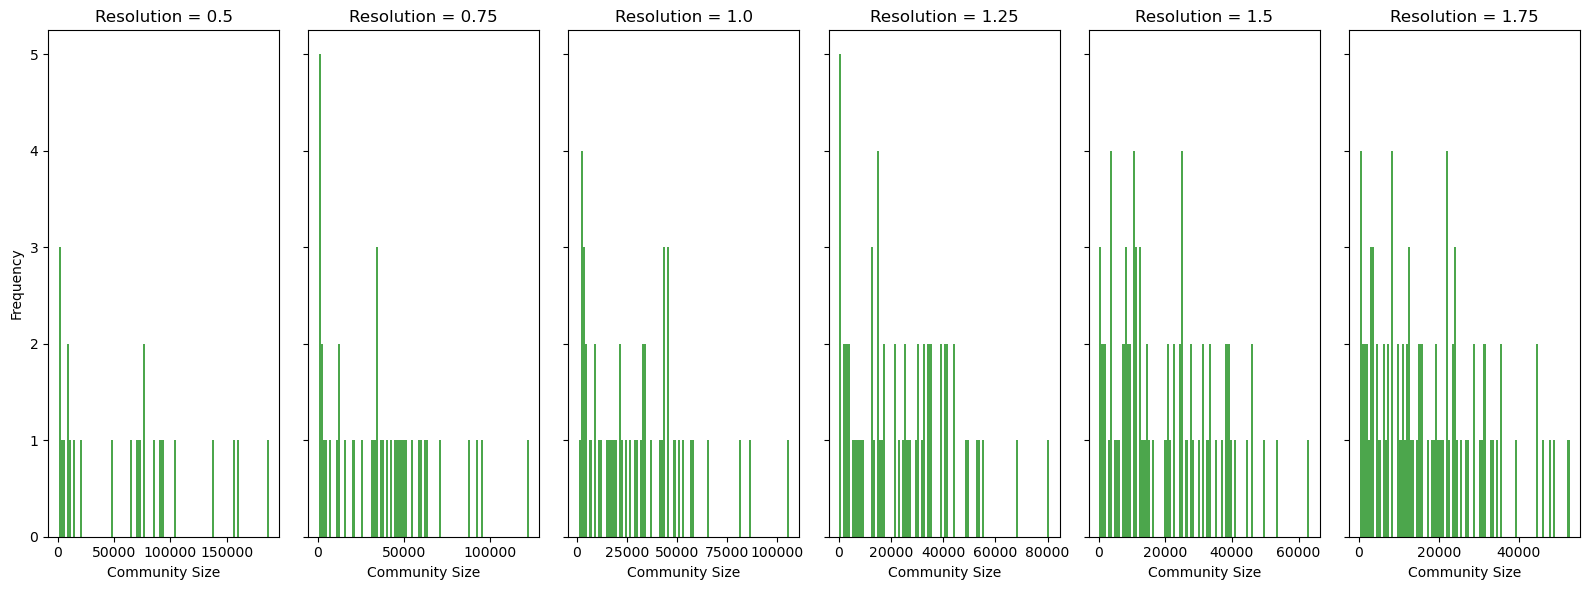

In [7]:
G = nx.from_pandas_edgelist(df, source='FromNodeID', target='ToNodeID', create_using=nx.Graph())
resolutions = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
communities_dict = {}
communities_details = []
min_community_size = 25

def compute_community_stats(reso):
    random.seed(123)
    patent_communities = nx.algorithms.community.louvain_communities(G, resolution=reso)
    communities = [len(pat_comm) for pat_comm in patent_communities if len(pat_comm)>=min_community_size]
    community_stats = {
        'Resolution': reso,
        'Community_count': len(communities),
        'p10': np.percentile(communities, 10),
        'p20': np.percentile(communities, 25),
        'p50': np.percentile(communities, 50),
        'p75': np.percentile(communities, 75),
        'p90': np.percentile(communities, 90)
    }
    return reso, communities, community_stats

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(compute_community_stats, reso): reso for reso in resolutions}
    for future in concurrent.futures.as_completed(futures):
        reso, communities, community_stats = future.result()
        communities_dict[reso] = communities
        communities_details.append(community_stats)
        print(f'Resolution {reso} completed')

communities_details_df = pd.DataFrame(communities_details).sort_values(by='Resolution', ascending=True)
print('Community Details:')
display(communities_details_df)

fig, axes = plt.subplots(1, len(resolutions), figsize=(16, 6), sharey=True)
for i, reso in enumerate(resolutions):
    ax = axes[i]
    ax.hist(communities_dict[reso], bins=100, alpha=0.7, color='green')
    ax.set_title(f'Resolution = {reso}')
    ax.set_xlabel('Community Size')
    if i == 0:  
        ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [9]:
selected_reso = 1
min_community_size = 25
random.seed(123)
patent_communities = nx.algorithms.community.louvain_communities(G, resolution=selected_reso)
filtered_communities = [community for community in patent_communities if len(community) >= min_community_size]

# Highest degree node
degree_dict = dict(G.degree())
highest_degree_node = max(degree_dict, key=degree_dict.get)
originalid_highest_degree_node = reverse_node_mapping.get(highest_degree_node, highest_degree_node)
highest_degree_comm = None
for comm in filtered_communities:
    if highest_degree_node in comm:
        highest_degree_comm = comm
        break
print(f'Community with the highest degree node ({originalid_highest_degree_node}) has size: {len(highest_degree_comm)}')

node_to_community = {}
for i, comm in enumerate(filtered_communities):
    for node in comm:
        node_to_community[node] = i

filtered_comm_nodes = [node for comm in filtered_communities for node in comm]
G_filtered_comm = G.subgraph(filtered_comm_nodes)
community_pos = nx.spring_layout(G_filtered_comm)

node_color = []
colormap = matplotlib.colormaps['tab20'] 
for node in G_filtered_comm.nodes():
    if node in highest_degree_comm:
        node_color.append('black')
    else:
        community_index = node_to_community[node]
        node_color.append(colormap(community_index / len(filtered_communities)))

internal_edges = []
external_edges = []

for u, v in G_filtered_comm.edges():
    if node_to_community[u] == node_to_community[v]:
        internal_edges.append((u, v))
    else:
        external_edges.append((u, v))

Community with the highest degree node (4723129) has size: 9169


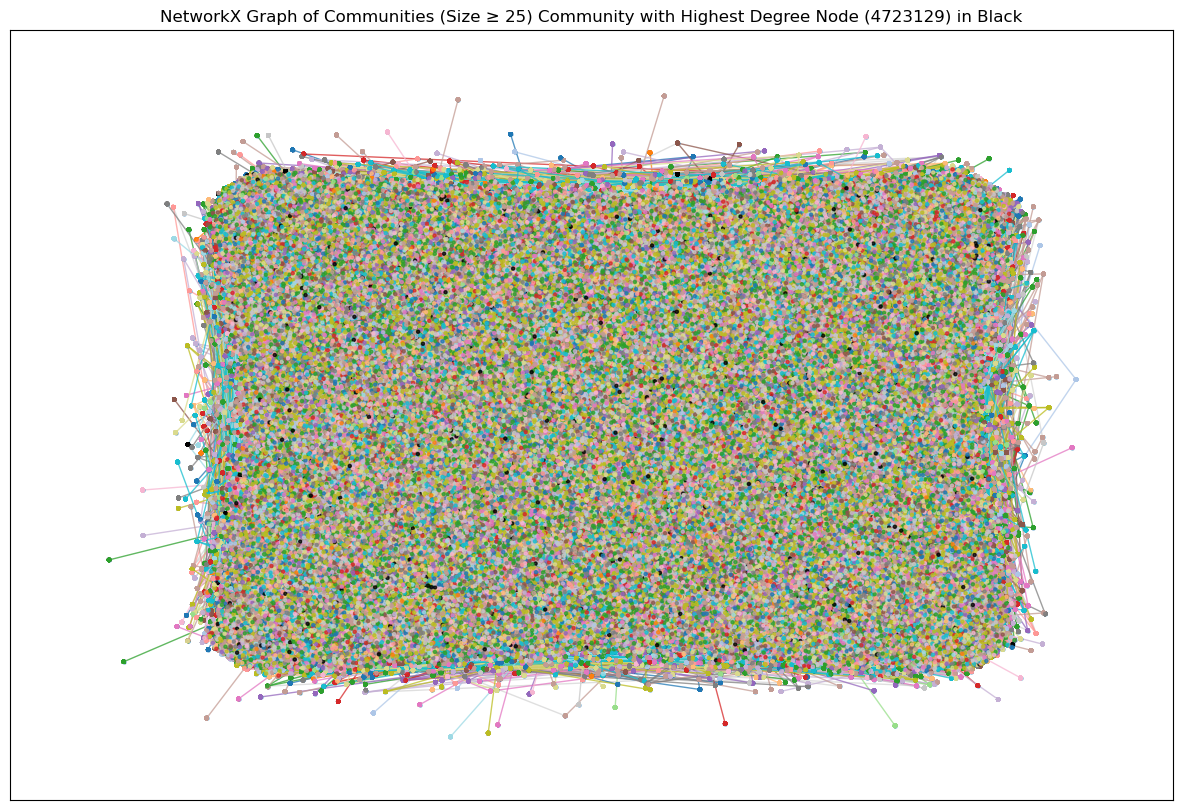

In [10]:
plt.rcParams.update({'figure.figsize': (15, 10)})

nx.draw_networkx(
    G_filtered_comm,
    pos=community_pos,
    node_size=5,
    edgelist=external_edges,
    edge_color='silver',
    alpha=0.5,
    with_labels=False
)

for i, comm in enumerate(filtered_communities):
    comm_internal_edges = [(u, v) for u, v in internal_edges if node_to_community[u] == i and node_to_community[v] == i]
    nx.draw_networkx(
        G_filtered_comm,
        pos=community_pos,
        node_color=node_color,
        node_size=5,
        edgelist=comm_internal_edges,
        edge_color=colormap(i / len(filtered_communities)), 
        alpha=0.75,
        with_labels=False  
    )

nx.draw_networkx_nodes(
    G_filtered_comm,
    pos=community_pos,
    node_color=node_color,
    node_size=5,
    alpha=0.75
)

plt.title(f'NetworkX Graph of Communities (Size ≥ {min_community_size}) Community with Highest Degree Node ({originalid_highest_degree_node}) in Black')
plt.show()

The simple NetworkX visualization of patent communities does not provide meaningful insights due to the sheer density and complexity of the network. With thousands of nodes and edges, the visualization appears as an indistinguishable mass, making it difficult to identify patterns, relationships, or key nodes through visual inspection alone. To address this challenge, summary statistics such as in-degree and out-degree can be analyzed for nodes within each community to understand the connectivity within and/or between communities

In [11]:
# Retrieve in-degree and out-degree from earlier dataframe + merge with community information
degree['community'] = degree.index.map(node_to_community)
degree = degree.dropna(subset=['community'])
degree['community'] = degree['community'].astype(int)

# Calculate stats per community for in-degree, out-degree, and combined-degree
community_stats = []
for i in range(len(filtered_communities)):
    community_nodes = list(filtered_communities[i])
    community_degree = degree.loc[community_nodes]
    community_stats.append({
        'Community': i +1,
        'Community Size': len(community_nodes),
        'Avg In-degree': community_degree['in_degree'].mean(),
        'Min In-degree': community_degree['in_degree'].min(),
        'Max In-degree': community_degree['in_degree'].max(),
        'Avg Out-degree': community_degree['out_degree'].mean(),
        'Min Out-degree': community_degree['out_degree'].min(),
        'Max Out-degree': community_degree['out_degree'].max(),
        'Avg Combined Degree': community_degree['combined_degree'].mean(),
        'Min Combined Degree': community_degree['combined_degree'].min(),
        'Max Combined Degree': community_degree['combined_degree'].max()
    })

community_stats_df = pd.DataFrame(community_stats)
display(community_stats_df)

,Community,Community Size,Avg In-degree,Min In-degree,Max In-degree,Avg Out-degree,Min Out-degree,Max Out-degree,Avg Combined Degree,Min Combined Degree,Max Combined Degree
0,1,8066,7.450781,0,251,7.747582,0,110,15.198364,8,253
1,2,3029,11.600198,0,278,13.391548,0,139,24.991746,8,293
2,3,52086,8.195868,0,401,8.787390,0,354,16.983258,8,403
3,4,1375,6.191273,0,64,6.614545,0,46,12.805818,8,66
4,5,41823,8.285465,0,233,8.827631,0,469,17.113096,8,469
5,6,155,17.129032,0,129,15.496774,0,49,32.625806,8,129
6,7,8811,7.306095,0,77,9.608217,0,164,16.914312,8,164
7,8,900,5.891111,0,30,8.268889,0,159,14.160000,8,159
8,9,744,6.424731,0,43,7.990591,0,61,14.415323,8,61
9,10,16123,8.093593,0,244,8.302983,0,141,16.396576,8,244


Looking into the smaller communities which potentially represent newer technical areas (i.e., communities 6, 23), we can see that the structure of communities can differ quite a bit. If more information about each node is available, we might be able to discern and make better sense of these patterns.

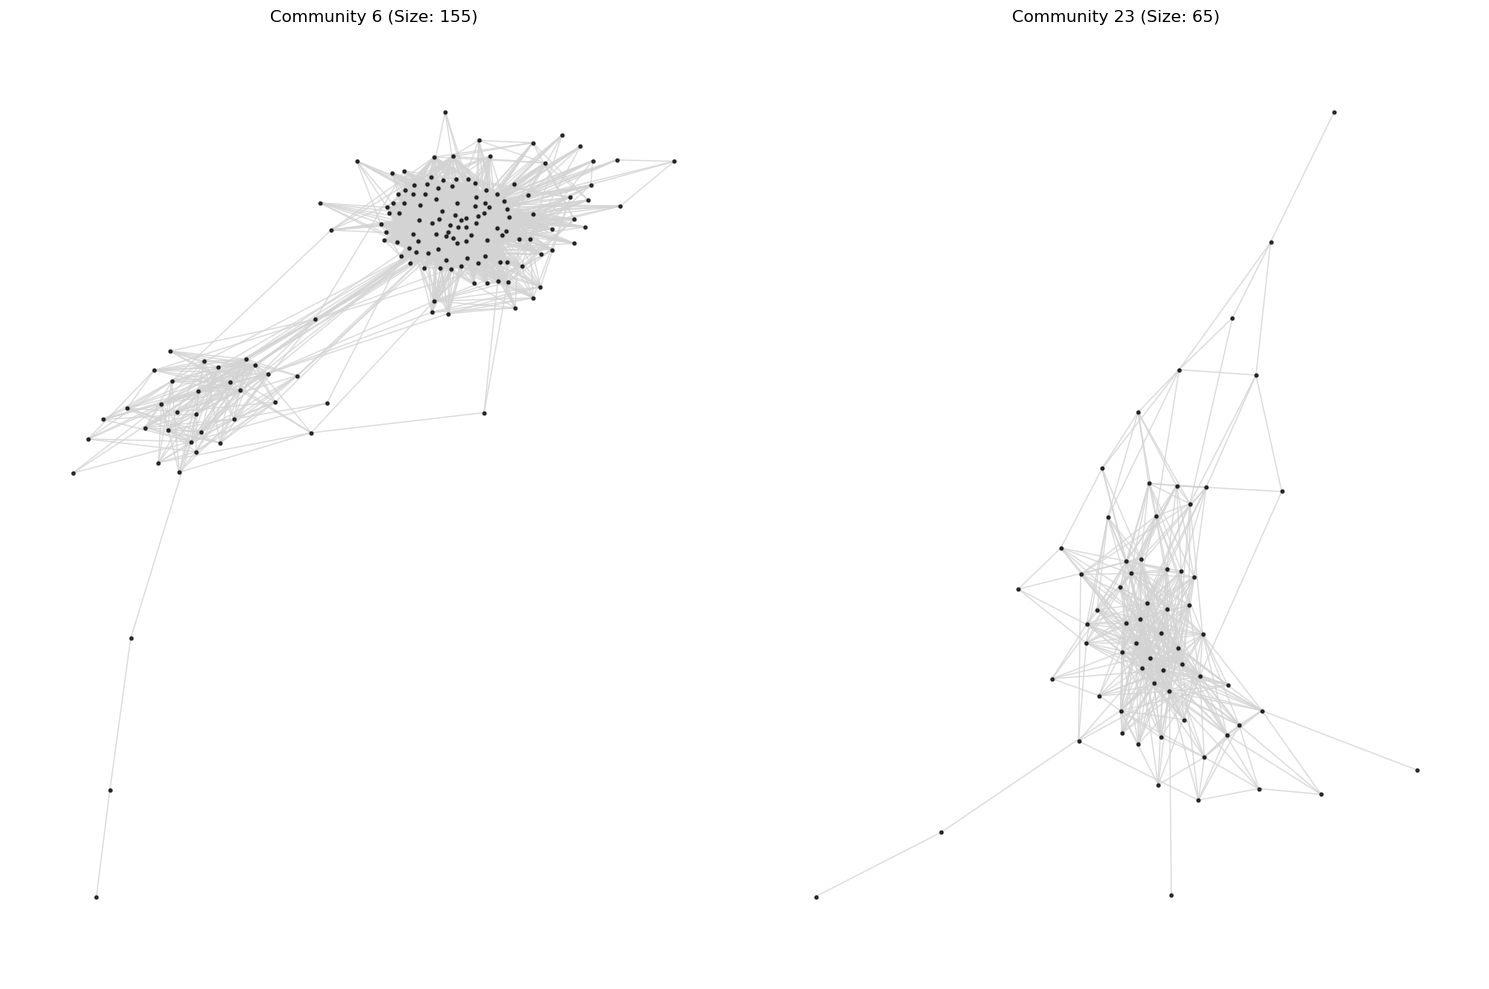

In [21]:
selected_communities = [6, 23]
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for ax, community_index in zip(axs, selected_communities):
    comm_nodes = list(filtered_communities[community_index - 1])
    G_comm = G.subgraph(comm_nodes)
    comm_pos = nx.spring_layout(G_comm)
    nx.draw_networkx(
        G_comm,
        pos=comm_pos,
        ax=ax,
        node_size=5,
        node_color='black',
        edge_color='lightgray',
        alpha=0.75,
        with_labels=False
    )
    ax.set_title(f'Community {community_index} (Size: {len(comm_nodes)})')
    ax.axis("off")

plt.tight_layout()
plt.show()

---
### 3. PageRank Algorithm on Communities

PageRank identifies the most influential nodes in a graph based on their connectivity. In the context of the patent citation network, it helps highlight key patents within each community by analyzing their connections. The PageRank score $r_i$ for a node $i$ is defined as:

$$
r_i = \frac{1 - d}{N} + d \sum_{j \in \mathcal{M}(i)} \frac{r_j}{|\mathcal{O}(j)|}
$$

Where:
- $d$ is the damping factor that sets the probability of following links in the network instead of jumping to a different part of the network randomly
- $N$ is the total number of nodes in the network
- $\mathcal{M}(i)$ is the set of nodes pointing to $i$
- $\mathcal{O}(j)$ is the set of nodes that $j$ points to

The PageRank algorithm is applied to communities detected by the Louvain algorithm to assess the importance of individual patents within their respective communities. Patents with the highest PageRank scores are considered the most influential within their communities, as they are highly connected to other patents in the same space. This analysis provides insight into the structure of influence within the patent citation network by identifying key patents in tightly-knit communities

In [ ]:
H = nx.from_pandas_edgelist(df, source='FromNodeID', target='ToNodeID', create_using=nx.DiGraph()) #directed graph
pagerank = nx.pagerank(H, alpha=0.85) #default alpha value (damping factor), but unlikely to matter since nodes are strongly connected to one another within a community
node_info = {node: (pagerank[node], node_to_community.get(node)) for node in pagerank}

influential_patents = {}

for community in set(node_to_community.values()):
    community_nodes = [node for node, comm in node_to_community.items() if comm == community]
    community_pagerank = {node: pagerank[node] for node in community_nodes if node in pagerank}
    
    if community_pagerank:
        most_influential_patent = max(community_pagerank, key=community_pagerank.get)
        influential_patents[community] = most_influential_patent

for community_id, influential_patent in influential_patents.items():
    original_influential_patent = reverse_node_mapping.get(influential_patent, influential_patent)  # Get original node ID
    print(f'Community {community_id} - Most Influential/Seminal Patent: {original_influential_patent} (PageRank: {pagerank[influential_patent]})')

Community 0 - Most Influential Patent: 3778614 (PageRank: 1.8428107713977034e-05)
Community 1 - Most Influential Patent: 3271922 (PageRank: 4.757233518961118e-06)
Community 2 - Most Influential Patent: 4367924 (PageRank: 2.2996081757480995e-05)
Community 3 - Most Influential Patent: 3772554 (PageRank: 4.634398495359187e-06)
Community 4 - Most Influential Patent: 3354129 (PageRank: 1.5790047985852704e-05)
Community 5 - Most Influential Patent: 3929992 (PageRank: 7.632049554160397e-06)
Community 6 - Most Influential Patent: 2587215 (PageRank: 4.360755338326172e-06)
Community 7 - Most Influential Patent: 3639945 (PageRank: 3.5233201527762833e-06)
Community 8 - Most Influential Patent: 3609014 (PageRank: 4.617744171257278e-06)
Community 9 - Most Influential Patent: 2297691 (PageRank: 1.3862800059211496e-05)
Community 10 - Most Influential Patent: 4834306 (PageRank: 7.109234758190655e-06)
Community 11 - Most Influential Patent: 2678457 (PageRank: 4.2507054852046365e-06)
Community 12 - Most 